In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

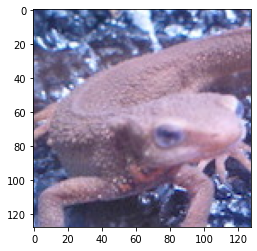

In [142]:
img = cv2.imread("../imori.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [206]:
class CannyEdgeDetection:
    def BGR2GRAY(self, img):
        b = img[:, :, 0].copy()
        g = img[:, :, 1].copy()
        r = img[:, :, 2].copy()
        output_image = (0.2126*r + 0.7152*g + 0.0722*b).astype("uint8")
        return output_image
    
    def gaussian_filter(self, img, ksize=5, sigma=1.4):
        K = np.zeros((ksize, ksize))
        for i in range(ksize):
            for j in range(ksize):
                x = i - (ksize - 1) // 2
                y = j - (ksize - 1) // 2
                a = -(x*x+y*y)/(2*(sigma**2))
                K[i, j] = 1/(2*np.pi*(sigma**2)) * np.exp(a)
        K /= np.sum(K)

        pad = ksize // 2
        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        output_image = input_image.copy()
        input_image[pad:H+pad, pad:W+pad] = img.copy().astype(np.float)
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
                output_image[pad+i, pad+j] = np.clip(output_image[pad+i, pad+j], 0, 255).astype("uint8")
        output_image = output_image[pad:pad+H, pad:pad+W]
        return output_image
    
    def sobel_filter_v(self, img):
        ksize = 3
        pad = ksize // 2
        K = [ [1, 2, 1], [0, 0, 0], [-1, -2, -1] ]

        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        input_image[pad:pad+H, pad:pad+W] = img.copy()
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
        output_image = np.clip(output_image[pad:pad+H, pad:pad+W], 0, 255).astype("uint8")
        return output_image
    
    def sobel_filter_h(self, img):
        ksize = 3
        pad = ksize // 2
        K = [ [1, 0, -1], [2, 0, -2], [1, 0, -1] ]

        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        input_image[pad:pad+H, pad:pad+W] = img.copy()
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
        output_image = np.clip(output_image[pad:pad+H, pad:pad+W], 0, 255).astype("uint8")
        return output_image
    
    def quantize_angle(self, a):
        angle = a.copy()
        angle *= 180 / np.pi
        while angle <= -22.5: angle += 180
        while angle > 157.5: angle -= 180
        
        quantized_angle = 0
        if 22.5 < angle <= 67.5:
            quantized_angle = 45
        elif 67.5 < angle <= 112.5:
            quantized_angle = 90
        elif 112.5 < angle <= 157.5:
            quantized_angle = 135
        return quantized_angle
    
    def non_maximum_suppression(self, angle, edge_):
        H, W = angle.shape
        edge = edge_.copy()
        edge_pad = np.zeros((H+2, W+2))
        edge_pad[1:1+H, 1:1+W] = edge_.copy()
        
        for i in range(1, H+1):
            for j in range(1, W+1):
                if angle[i-1, j-1] == 0:
                    if np.amax([edge_pad[i, j], edge_pad[i, j-1], edge_pad[i, j+1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 45:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j+1], edge_pad[i+1, j-1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 90:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j], edge_pad[i+1, j]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 135:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j-1], edge_pad[i+1, j+1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
        edge = np.clip(edge, 0, 255)
        return edge
    
    def apply_threshold(self, img, HT=50, LT=20):
        H, W = img.shape
        input_img = np.zeros((H+2, W+2))
        input_img[1:1+H, 1:1+W] = img.copy()
        
        output_img = img.copy()
        for i in range(1, H+1):
            for j in range(1, W+1):
                if input_img[i, j] >= HT:
                    output_img[i-1, j-1] = 255
                elif input_img[i, j] <= LT:
                    output_img[i-1, j-1] = 0
                elif len(np.where(input_img[i-1:i+2, j-1:j+2] > HT)[0]) > 0:
                    output_img[i-1, j-1] = 255
        return output_img
    
    def canny(self, img):
        img_gray = self.BGR2GRAY(img)
        img_gaussian = self.gaussian_filter(img_gray, ksize=5, sigma=1.4)
        img_sobel_v = self.sobel_filter_v(img_gaussian)
        img_sobel_h = self.sobel_filter_h(img_gaussian)
        
        H, W = img_gray.shape
        edge = np.sqrt(np.power(img_sobel_h.astype(np.float32), 2) + np.power(img_sobel_v.astype(np.float32), 2))
        img_sobel_h = np.maximum(img_sobel_h, 1e-5)
        angle = np.arctan2(img_sobel_v, img_sobel_h)
        for i in range(H):
            for j in range(W):
                angle[i, j] = self.quantize_angle(angle[i, j])
                
        edge_nms = self.non_maximum_suppression(angle, edge)
        edge_out = self.apply_threshold(edge_nms, HT=50, LT=20)
        
        plt.figure(figsize=(15, 15))
        plt.subplot(2, 2, 1)
        plt.imshow(edge.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Edge Strength")
        plt.subplot(2, 2, 2)
        plt.imshow(angle.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Edge Angle")
        plt.subplot(2, 2, 3)
        plt.imshow(edge_nms.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Non-maximum Suppression")
        plt.subplot(2, 2, 4)
        plt.imshow(edge_out.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Canny")
        plt.show()
        
        return edge_out

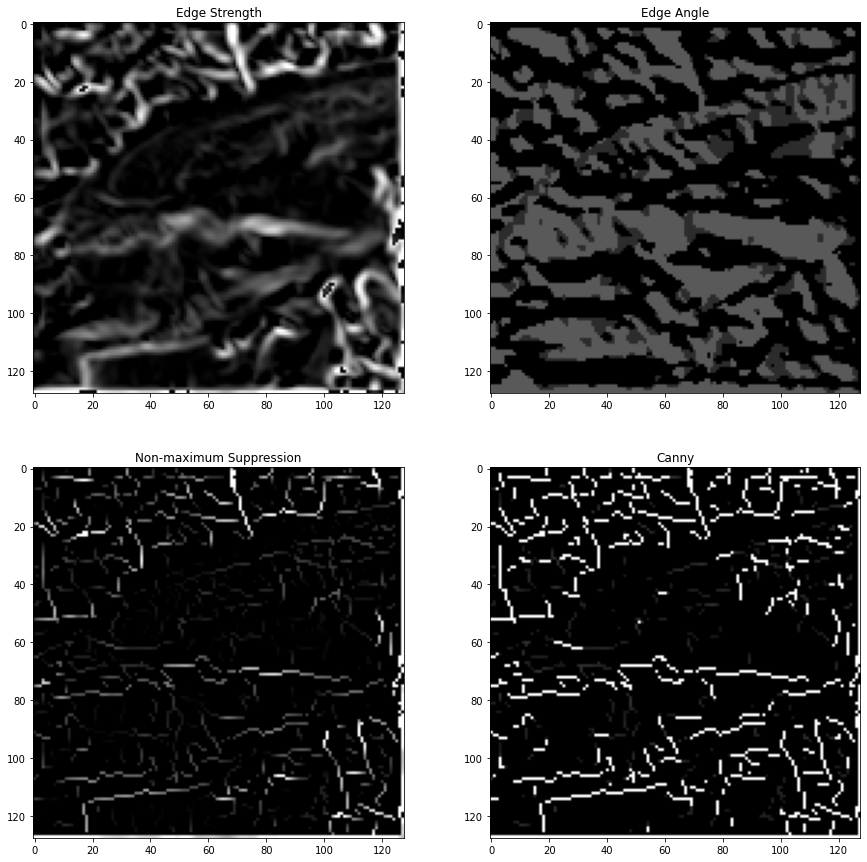

array([[  0.,   0.,   0., ...,   0.,   0., 255.],
       [  0.,   0.,   0., ...,   0.,   0., 255.],
       [  0.,   0.,   0., ...,   0.,   0., 255.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 255.],
       [  0.,   0.,   0., ...,   0.,   0., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [207]:
can = CannyEdgeDetection()
can.canny(img)